### **Práctica 2 - Machine Learning III**

**Objetivo**: 
1. Analizar el conjunto de datos. 
2. Crear un sistema de recomendación de artistas para usuarios.
   
**Entregar**: Este cuaderno de jupyter con el trabajo hecho y comentado.

**Datos**: 

Los datos suministrados ya han sido procesados, limpiados y estructurados para simplificar su manejo y análisis. 

Para aquellos interesados en explorar y manipular el conjunto de datos original, así como entender la estructura, podéis descargarlo directamente aquí: 

https://grouplens.org/datasets/hetrec-2011/.

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm
import cornac
from cornac.utils import cache
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.models import UserKNN

In [45]:

artists = pd.read_csv('./artists.dat', header=0, sep='\t')
user_tag_artist = pd.read_csv('./user_taggedartists.dat', header=0, sep='\t')
tags = pd.read_csv('tags.dat', header=0, sep='\t', encoding='latin-1')
users = pd.read_csv('user_artists.dat',header=0, sep='\t')


## EDA

In [46]:
artists.head()


,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [47]:
user_tag_artist.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


In [48]:
tags.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [49]:
users.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [50]:
unique_artists = len(artists['id'].unique())
print('There are', unique_artists, 'unique artists in the dataset.')

unique_users = len(users['userID'].unique())
print('There are', unique_users, 'unique users in the dataset.')

There are 17632 unique artists in the dataset.
There are 1892 unique users in the dataset.


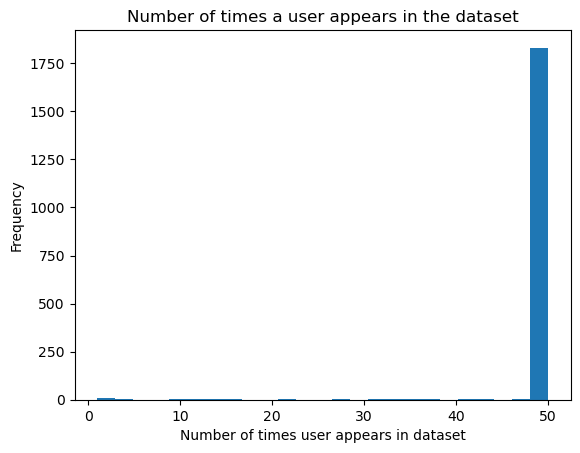

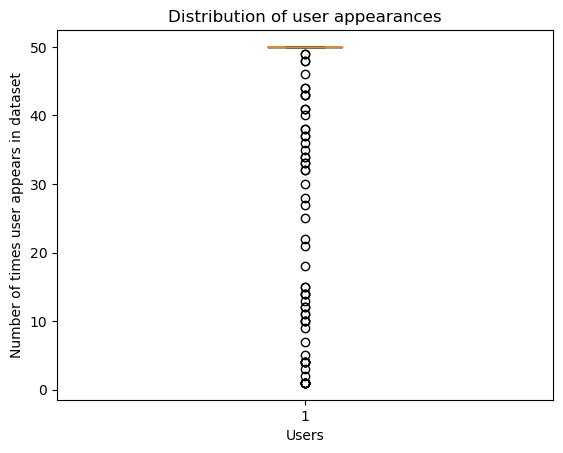

In [51]:
import matplotlib.pyplot as plt

user_artist_count = users['userID'].value_counts()

plt.hist(user_artist_count, bins=25)
plt.xlabel('Number of times user appears in dataset')
plt.ylabel('Frequency')
plt.title('Number of times a user appears in the dataset')
plt.show()

plt.boxplot(user_artist_count)
plt.xlabel('Users')
plt.ylabel('Number of times user appears in dataset')
plt.title('Distribution of user appearances')
plt.show()



In [52]:
Q1 = user_artist_count.quantile(0.25)
Q3 = user_artist_count.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = user_artist_count[(user_artist_count < lower_bound) | (user_artist_count > upper_bound)]
percentage_of_outliers = (len(outliers) / len(user_artist_count))

percentage_of_outliers = round(percentage_of_outliers, 3)
print(str(percentage_of_outliers) + " of the data are outliers")

0.033 of the data are outliers


In [53]:
# Remove outliers
users = users[users['userID'].isin(user_artist_count[user_artist_count < upper_bound].index)]

In [54]:
top_artists = users.groupby('artistID')['weight'].sum()
# add the name of the artists to the top_artists series
top_artists = top_artists.reset_index()
top_artists = top_artists.merge(artists[['id', 'name']], left_on='artistID', right_on='id')
top_artists = top_artists.drop('id', axis=1)
top_artists = top_artists.sort_values('weight', ascending=False)
top_artists.head(10)



,artistID,weight,name
63,289,249303,Britney Spears
95,344,56571,Taylor Swift
15,89,45774,Lady Gaga
62,288,31489,Rihanna
9,67,23383,Madonna
10,72,17545,Depeche Mode
162,533,16138,Oasis
20,157,14311,Michael Jackson
66,292,12789,Christina Aguilera
133,461,8518,Miley Cyrus


In [55]:
#remove the artist with id 289 as 5 times larger than others
users = users[users['artistID'] != 289]

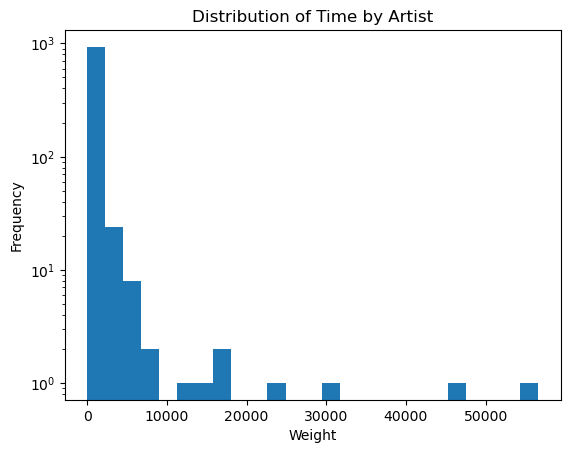

In [56]:
users.groupby('artistID')['weight'].sum().plot(kind='hist', bins=25)
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Distribution of Time by Artist')
plt.show()


## Sistema de Recomendacion

Hemos hecho el siguiente modelo de recomendación memory-based pero hemos pensado que el modelo optimo es un implicit que viene a continuación

In [57]:
users.head()

,userID,artistID,weight
1600,35,186,1
1601,35,212,4
1602,35,444,1
1603,35,920,1
1604,35,964,1


In [58]:
def userknn_cornac(df:pd.DataFrame):

  #df = df.astype({'userID':object, 'artistID':object})
  records = df.to_records(index=False)
  result = list(records)

  K = 3  # number of nearest neighbors
  VERBOSE = False
  SEED = 42
  uknn_cosine = UserKNN(k=K, similarity="cosine", name="UserKNN-Cosine", verbose=VERBOSE)
  uknn_cosine_mc = UserKNN(k=K, similarity="cosine", mean_centered=True, name="UserKNN-Cosine-MC", verbose=VERBOSE)
  uknn_pearson = UserKNN(k=K, similarity="pearson", name="UserKNN-Pearson", verbose=VERBOSE)
  uknn_pearson_mc = UserKNN(k=K, similarity="pearson", mean_centered=True, name="UserKNN-Pearson-MC", verbose=VERBOSE)
  
  # Metrics
  rec_100 = cornac.metrics.Recall(k=100)
  rec_500 = cornac.metrics.Recall(k=500)
  prec_10 = cornac.metrics.Precision(k=10)
  rmse = cornac.metrics.RMSE()
  mae = cornac.metrics.MAE()
  
  ratio_split = RatioSplit(result, test_size=0.1, seed=SEED, verbose=VERBOSE)
  cornac.Experiment(eval_method=ratio_split,
                    models=[uknn_cosine, uknn_cosine_mc, uknn_pearson, uknn_pearson_mc],
                    metrics=[rec_100, rec_500, prec_10, rmse, mae],
                    ).run()
  
  userknn_models = {'uknn_cosine': uknn_cosine, 'uknn_cosine_mc': uknn_cosine_mc,
                'uknn_pearson': uknn_pearson, 'uknn_pearson_mc': uknn_pearson_mc}
  
  return userknn_models

userknn_models = userknn_cornac(users)


TEST:
...
                   |       MAE |      RMSE | Precision@10 | Recall@100 | Recall@500 | Train (s) | Test (s)
------------------ + --------- + --------- + ------------ + ---------- + ---------- + --------- + --------
UserKNN-Cosine     | 1058.0665 | 1215.6493 |       0.0250 |     0.2458 |     0.4281 |    0.0040 |   0.0593
UserKNN-Cosine-MC  |  921.8277 |  972.1176 |       0.0094 |     0.2396 |     0.4156 |    0.0040 |   0.0625
UserKNN-Pearson    |  921.8277 |  972.1176 |       0.0094 |     0.2396 |     0.4156 |    0.0040 |   0.0685
UserKNN-Pearson-MC |  921.8277 |  972.1176 |       0.0094 |     0.2396 |     0.4156 |    0.0030 |   0.0975



In [59]:
model = userknn_models.get('uknn_pearson')
list(model.uid_map.items())[:5]

[(701, 0), (819, 1), (526, 2), (486, 3), (510, 4)]

In [60]:
import pandas as pd
def userRecomendations(UID, model, artists, TOPK=5):
  results = []
  prods = list(model.iid_map.keys())
  ids = list(model.iid_map.values())
  for i in range(len(model.iid_map)-1):
      results.append((prods[i], model.score(model.uid_map[UID], ids[i])))
  
  results = sorted(results, key=lambda x: x[1], reverse=True)
  
  df = pd.DataFrame(results, columns=['productID', 'weight'])
  return df.head(TOPK).merge(artists, left_on='productID', right_on='id')[['name', 'weight']]


userRecomendations(701, model, artists)

,name,weight
0,Manic Street Preachers,2671.977252
1,The Kills,2560.977253
2,Narkotiki,2072.977258
3,Leona Lewis,1910.069116
4,Aura Dione,1551.603395


## Implicit

In [61]:

import sys
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
%matplotlib inline

import cornac
from cornac.utils import cache
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.models import MF, BPR, WMF

import tensorflow as tf

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")
print(f"Tensorflow version: {tf.__version__}")

SEED = 42
VERBOSE = False

System version: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
Cornac version: 2.0
Tensorflow version: 2.15.0


In [67]:
param_grid = {
    "k": [10, 20, 30, 40, 50],
    "learning_rate": [0.001, 0.01, 0.1],
    "lambda_u": [0.001, 0.01],
    "lambda_v": [0.001, 0.01],
}

In [68]:
wmfs = []
for k in param_grid["k"]:
      for learning_rate in param_grid["learning_rate"]:
          for lambda_u in param_grid["lambda_u"]:
            for lambda_v in param_grid["lambda_v"]:
                wmf = WMF(k=k, max_iter=100, learning_rate=learning_rate, lambda_u=lambda_u, lambda_v=lambda_v, verbose=VERBOSE, seed=SEED, name=f"WMF(K={k}, learning_rate={learning_rate}, lambda_u={lambda_u}, lambda_v={lambda_v})")
                wmfs.append(wmf)

eval_metrics = [
  cornac.metrics.RMSE(), 
  cornac.metrics.AUC(),
  cornac.metrics.Precision(k=10),
  cornac.metrics.Recall(k=10),
  cornac.metrics.FMeasure(k=10),
  cornac.metrics.NDCG(k=[10, 20, 30]),
  cornac.metrics.MRR(),
  cornac.metrics.MAP()
]

df = users.astype({'userID':object, 'artistID':object})
records = df.to_records(index=False)
result = list(records)

rs = RatioSplit(result, test_size=0.2, seed=SEED, verbose=VERBOSE)

cornac.Experiment(eval_method=rs, models=wmfs, metrics=eval_metrics).run()

TypeError: WMF.__init__() got an unexpected keyword argument 'lambda_reg'